![image.png](https://img.freepik.com/free-vector/store-buildings-shopping-area-with-parking-scene-illustration_107791-4003.jpg?w=2000&t=st=1679653405~exp=1679654005~hmac=61a5177e5df89555b2947029ab170de95c77980aac7c26d62271ae238af28e25)
<a href="https://www.freepik.com/free-vector/shops-commercial-buildings-exterior-city-street-cartoon-summer-town-with-cafe-library-pharmacy-supermarket-facade-modern-architecture-auto-parts-store-boutique_10798318.htm#page=2&query=store%20illustration&position=13&from_view=search&track=ais">Image by upklyak</a> on Freepik

# Introduction

**Description**

In this time-series 'getting-started' competition, we are asked to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. We need a model that can predict unit sales for thousands of items sold at different stores.
For this competition we have different datasets describing sales, stores, holiday data and more between 2013 and 2017 in Ecuador.

**Goal**

To predict the sales **per product, per store** **for the next 16 days.**

**Metric**

The evaluation metric used for this competition is
**Root-Mean-Squared-Logarithmic-Error** (**RMSLE**). (Taking logs means that errors in predicting big salesnumbers and smaller salesnumbers will affect the result more evenly.)

In [1]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
from re import search

random.seed(333)
pd.options.mode.chained_assignment = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1. Exploratory Data Analysis:

# 1.1 Dataframes & NAs

As a first step of the EDA we would like to know what our data looks like, and if there are any NAs in the dataset.

We have different data sets to our disposal:

- **holiday_events**: a list with all ecuadorian holidays and events;
- **oil**: a list of oilprices meant to serve as an economic indicator of Ecuador;
- **stores**: a dataset with information about our stores: includes city, state, type and others;
- **transactions**: a dataset containing the number of aggregated transactions for each store on each day;
- **test**: general testset of 16 days of sales we will need to predict;
- **train**: a huge trainset with about 4 years of data to predict our test sales data.

This notebook makes use of all datasets except for the oilprices as on the surface it didn't seem to give any improvement in the modelling results. This could potentially be added in a future update of this notebook if it does happen to be useful.

In [2]:
# Read train/test data and check colnames & NA's:

original_train = pd.read_csv('train.csv')
original_test = pd.read_csv('test.csv')

# Dataframe info:
print(original_train.info())

# Check NAs:
original_train.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

We have ID, date, store number, (product) family, saleprice and promotion columns.
Our train and test datasets have zero missing values.

In [3]:
# Find out how many stores, products and dates are in our data:

original_train['store_nbr'].unique().__len__() # 54 stores
original_train['family'].unique().__len__() # 33 products

len(original_train) / 54 / 33 # 1684 days (between 4 and 5 years)
original_train['date'].iloc[0] # 2013-01-01 is start
original_train['date'].iloc[-1] # 2017-08-15 is end

len(original_test) / 54 / 33 # 16 days
original_test['date'].iloc[0] # 2017-08-16 is test start
original_test['date'].iloc[-1] # 2017-08-31 is test end

'2017-08-31'

Our main datasets consist of:

- **54 stores**

- **33 productgroups**


We are asked to predict the sales for each productgroup (33), at each store (54) during 16 consecutive days.
This means we will have to do 33 * 54 * 16 = 28512 predictions. To make this more manageable, we can create a dataframe and predictions for each individual productgroup. This means we will create 33 dataframes that each do 864 predictions.

For faster runtime and better oversight we will first create different dataframes that we then merge together through a pipeline into 33 individual product dataframes.

# 1.2 Visualization

Since we are going to create a dataframe per product, it is best to create a graph to see the sales evolution for each family over the years. We want the sum of sales for each month, for each year, for each family, so we aggregate accordingly.

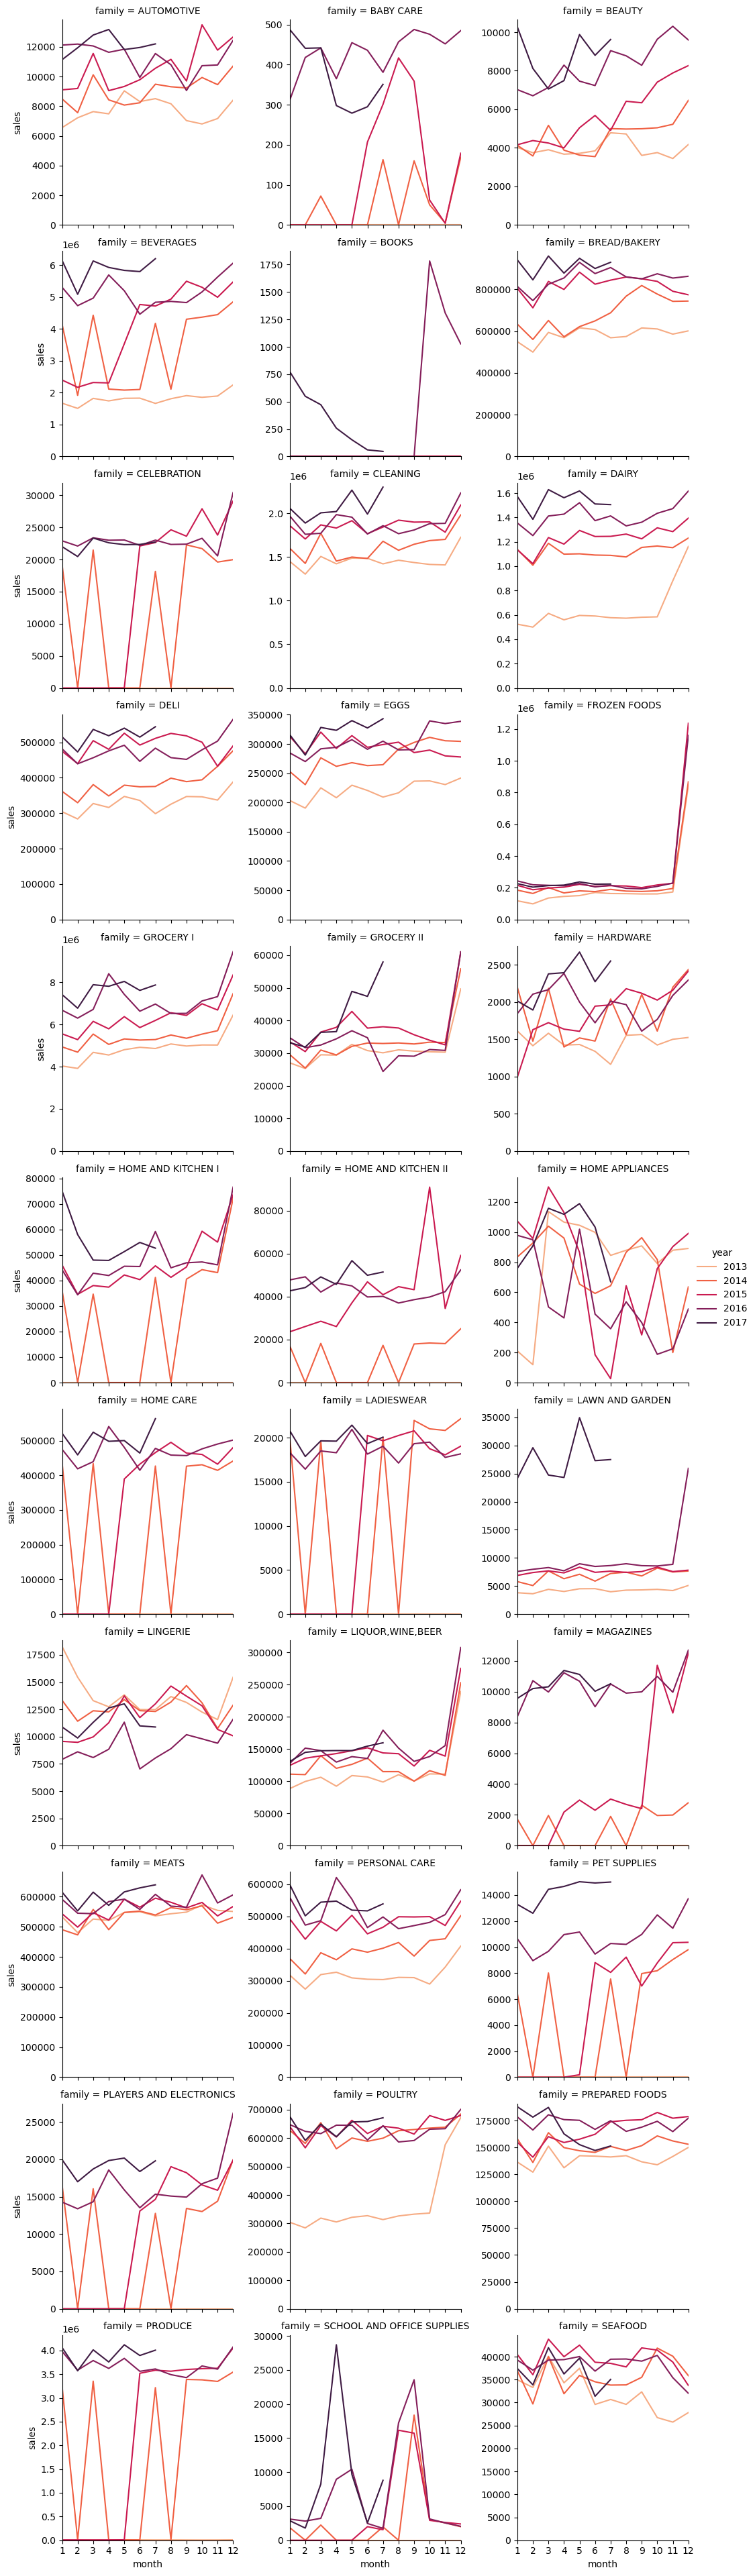

In [4]:
original_train['date'] = pd.to_datetime(original_train['date'])
original_train['year'] = original_train['date'].dt.year
original_train['month'] = original_train['date'].dt.month

monthly_sales = original_train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()

# The value of the last month (for each 33 products) we change to nan, as otherwise it will distort
# the graph since this month's data is incomplete:
for x in range(33):
    z = 55+(x*56)
    monthly_sales.at[z,'sales'] = np.nan 

# We use seaborn's FacetGrid with a col_wrap of 3 to show all the graphs in rows of three.
# We also need sharey = False so that the y axis of all the graphs is not shared but individual.
product_lineplots = sns.FacetGrid(monthly_sales, col="family", hue='year', sharey=False, height=3.5, col_wrap=3, palette='rocket_r')
product_lineplots.map(sns.lineplot, "month", 'sales')
product_lineplots.add_legend()
product_lineplots.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

*Some observations:*

Some months show weird behaviour for some of our products (for example Pet Supplies, Produce,...):
- 2014: feb(2), apr(4), may(5), jun(6), aug(8)
- 2015: jan(1), feb(2), mar(3), apr(4), may(5)

**December:**

Seems to be the best sales month for many products, probably because it's a holiday period with both christmas and new year's eve.

**Books:**

Seems like the 'books' category is at the end of being phased out, it's probably a good idea to set this prediction to zero.

**School And Office Supplies:**

Seems to peak in April, but before this year more in August-September. These dates are particularly interesting for us since our prediction also takes place in the middle of this peak (end of August).

In [5]:
# Create a graph for allsales:

total_monthly_sales = original_train.groupby(['year','month']).agg({"sales" : "sum"}).reset_index()

total_monthly_sales.at[55,'sales'] = np.nan

total_plot = sns.lineplot(x='month', y='sales', hue='year', palette='rocket_r', data=total_monthly_sales)
total_plot.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

[(1.0, 12.0),
 (0.0, 30639353.96948252),

# 1.3 Create Variables

We will create:

- An ***independant*** dataframe: where one day = one row, independant of store numbers and product groups, here we create variables that are depending on the date, irrelevant of the store (for example, the day of the week)

- An ***all stores*** dataframe: we create a dataframe where we aggregate all 54 stores, and add variables that are depending on the stores (for example: store_closed)

- A ***group of product*** dataframes: the main dataframe where we aggregate per product and then add the previously created data from the independant df and all stores df.

# 1.3.1 Independant Dataframe

For the **independant** dataframe we create the following functions:
- **create_date_df**: small function to aggregate the dataframe into a smaller one grouped by date

- **create_paydays**: for the government jobs (the biggest employer in Ecuador), wages are paid on both the first day of the month, and the 15th. This function creates the payday columns: both effective paydays, as a scale that counts up to have a var that shows how long ago people have been paid.

- **onehotencode**: function to turn the chosen columns into different binary columns (we will also use this function for our all stores df).

- **independant pipeline**: pipeline that merges all previous functions to create one dataframe. Here we also add extra variables: regular date variables, a variable that indicates when the earthquake happened, and a variable for when school starts (to increase our school and office supplies score).

In [6]:
def create_date_df(df, store_nr):

    single_store_df = df[df['store_nbr'] == store_nr]
    single_store_series = single_store_df.groupby(["date"]).sum(numeric_only=True)

    return single_store_series

In [7]:
def create_payday_anchors(df):

    df.reset_index(inplace=True)
    df['Payday'] = 0

    for id, row in df.iterrows():

        if search('-01$', row['date']):
            df.at[id - 1, 'Payday'] = 1

        if search('-15$', row['date']):
            df.at[id, 'Payday'] = 1

    df = df[:-1]

    return df

In [8]:
def onehotencode(df, list_of_variables):

    column_name_list = list()
    my_category_list = list()

    for column in list_of_variables:

        categories = df[column].unique().tolist()

        for i in categories:

            this_list = ((df[column] == i) * 1).tolist()

            column_name_list.append(column + str(i))
            my_category_list.append(this_list)

            print('Finished ' + str(i))

        print(str(column) + ' is done.')

    onehotencode_df = pd.DataFrame(my_category_list).transpose()
    onehotencode_df.columns = np.asarray(column_name_list)

    return onehotencode_df

In [9]:
def independant_pipeline():

    original_train = pd.read_csv('train.csv')
    original_test = pd.read_csv('test.csv')

    # Get one store one product DF:
    one_store_df = create_date_df(original_train, 1)
    one_store_df_test = create_date_df(original_test, 1)
    one_store_df.drop('sales', axis=1, inplace=True)

    one_store_df = pd.concat([one_store_df, one_store_df_test])

    del original_train
    del original_test

    ########################
    # Add Paydays          #
    ########################

    one_store_df = create_payday_anchors(one_store_df)

    payday_series = one_store_df['Payday']
    payday_count = 0
    payday_scale_list = list()

    for x in range(payday_series.__len__()):

        if payday_series[x] == 1:
            payday_count = 0
            payday_scale_list.append(payday_count)
        else:
            payday_count += 1
            payday_scale_list.append(payday_count)

    one_store_df['Payday_Scale'] = payday_scale_list

    one_store_df.drop(['id'], axis=1, inplace=True)

    ######################
    # Add Date Variables #
    ######################

    dayoftheweek_list = list()
    dayoftheyear_list = list()
    monthoftheyear_list = list()
    year_list = list()

    for x in range(1700): # because 1700 different days

        thisdate = one_store_df['date'][x]
        thisdayoftheweek = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%A')
        thisdayoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%j')
        thismonthoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%B')
        thisyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%Y')

        dayoftheweek_list.append(thisdayoftheweek)
        dayoftheyear_list.append(thisdayoftheyear)
        monthoftheyear_list.append(thismonthoftheyear)
        year_list.append(thisyear)

    one_store_df['DayOfTheWeek'] = dayoftheweek_list
    one_store_df['DayOfTheYear'] = dayoftheyear_list
    one_store_df['MonthOfTheYear'] = monthoftheyear_list
    one_store_df['Year'] = year_list

    one_store_df['DayOfTheYear'] = pd.to_numeric(one_store_df['DayOfTheYear'])

    # Convert DayOfTheWeek to numeric:

    dayoftheweek_scale_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
                               'Friday': 5, 'Saturday': 6, 'Sunday': 7}

    one_store_df['dayoftheweek_scale'] = one_store_df['DayOfTheWeek'].map(dayoftheweek_scale_dict)

    ########################
    # OneHotEncode         #
    ########################

    onehotcolumnlist = ('DayOfTheWeek', 'MonthOfTheYear', 'Year')
    onehotencode_df = onehotencode(one_store_df, onehotcolumnlist)
    one_store_df = pd.concat([one_store_df, onehotencode_df], axis=1)

    ########################
    # Drop Some Cols       #
    ########################

    one_store_df.drop(['store_nbr', 'DayOfTheWeek', 'onpromotion'], axis=1, inplace=True)

    return one_store_df

In [10]:
# --- Execute Pipeline --- #

independant_df = independant_pipeline()

Finished Tuesday
Finished Wednesday
Finished Thursday
Finished Friday
Finished Saturday
Finished Sunday
Finished Monday
DayOfTheWeek is done.
Finished January
Finished February
Finished March
Finished April
Finished May
Finished June
Finished July
Finished August
Finished September
Finished October
Finished November
Finished December
MonthOfTheYear is done.
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Year is done.


# 1.3.2 All Stores Dataframe

For our **all stores** dataframe we create the following functions:
- **create_multi_store_one_product_df**: small function to create a df aggregated on stores and filtered on one product.

- **create_holiday_variables**: function that creates all the different holiday variables (depending on the store location). 

- **create_location_variables**: function that creates some extra variables based on the store locations. This is external data that we add that was not available in our initial dataframes on kaggle. We specifically look at elevation (Ecuador is a mountainous country) and city density (a store in a big city might have very different effects at certain times than a store in a sparsely populated town).

- **all_stores_pipeline**: pipeline function that merges the previous functions (and also performs onehotencode) to create our all stores df.

In [11]:
def create_multi_store_one_product_df(df, product_name):

    multistore_single_product = df[df['family'] == product_name]

    return multistore_single_product

In [12]:
def create_holiday_variables(df):

    holidays = pd.read_csv('holidays_events.csv')

    holidays = holidays[holidays['transferred'] == False]
    holidays['holiday_type'] = holidays['type']
    holidays.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

    national_holidays = holidays[holidays['locale'] == 'National']
    national_holidays['national_holiday_type'] = national_holidays['holiday_type']
    national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
    df = pd.merge(df, national_holidays, how='left', on=['date'])

    state_holidays = holidays[holidays['locale'] == 'Regional']
    state_holidays['state'] = state_holidays['locale_name']
    state_holidays['state_holiday_type'] = state_holidays['holiday_type']
    state_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    df = pd.merge(df, state_holidays, how='left', on=['date', 'state'])

    city_holidays = holidays[holidays['locale'] == 'Local']
    city_holidays['city'] = city_holidays['locale_name']
    city_holidays['city_holiday_type'] = city_holidays['holiday_type']
    city_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    city_holidays.drop([265], axis=0, inplace=True)
    df = pd.merge(df, city_holidays, how='left', on=['date', 'city'])

    df['holiday_type'] = np.nan
    df['holiday_type'] = df['holiday_type'].fillna(df['national_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['state_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['city_holiday_type'])
    df.drop(['national_holiday_type', 'state_holiday_type', 'city_holiday_type'], axis=1, inplace=True)

    return df

In [13]:
def create_location_variables(df):

    stores = pd.read_csv('stores.csv')

    # stores['city'].unique()
    # ['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
    #  'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
    #  'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
    #  'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen']

    # Height dict:
    Height = {'Quito': 2850, 'Santo Domingo': 550, 'Cayambe': 2830, 'Latacunga': 2860,
              'Riobamba': 2754, 'Ibarra': 2225, 'Guaranda': 2668, 'Puyo': 950,
              'Ambato': 2577, 'Guayaquil': 0, 'Salinas': 0, 'Daule': 0,
              'Babahoyo': 0, 'Quevedo': 75, 'Playas': 0, 'Libertad': 36,
              'Cuenca': 2560, 'Loja': 2060, 'Machala': 0, 'Esmeraldas': 15,
              'Manta': 0, 'El Carmen': 250}

    # Elevation:
    # 0 = 0 - 200 (10)
    # 1 = 200-700 (2)
    # 2 = 700-1500 (1)
    # 3 = 1500-2300 (2)
    # 4 = 2300-3000 (7)

    Population = {'Quito': 2000000, 'Santo Domingo': 460000, 'Cayambe': 40000, 'Latacunga': 100000,
                  'Riobamba': 157000, 'Ibarra': 150000, 'Guaranda': 35000, 'Puyo': 40000,
                  'Ambato': 350000, 'Guayaquil': 2750000, 'Salinas': 50000, 'Daule': 130000,
                  'Babahoyo': 105000, 'Quevedo': 200000, 'Playas': 40000, 'Libertad': 105000,
                  'Cuenca': 445000, 'Loja': 200000, 'Machala': 260000, 'Esmeraldas': 200000,
                  'Manta': 240000, 'El Carmen': 120000}

    # Population:
    # 0 = 0-60000 (5)
    # 1 = 60000-160000 (12)
    # 2 = 160000-280000 (3)
    # 3 = 280000+ (2)

    Size = {'Quito': 372, 'Santo Domingo': 60, 'Cayambe': 378, 'Latacunga': 370,
            'Riobamba': 59, 'Ibarra': 242, 'Guaranda': 520, 'Puyo': 88,
            'Ambato': 47, 'Guayaquil': 345, 'Salinas': 27, 'Daule': 475,
            'Babahoyo': 175, 'Quevedo': 300, 'Playas': 280, 'Libertad': 28,
            'Cuenca': 71, 'Loja': 44, 'Machala': 67, 'Esmeraldas': 70,
            'Manta': 60, 'El Carmen': 1250}

    stores["City_Population"] = stores['city'].map(Population)
    stores["City_Elevation"] = stores['city'].map(Height)
    stores["City_Size"] = stores['city'].map(Size)
    stores["City_Density"] = round(stores["City_Population"] / stores["City_Size"],0)
    stores["City_Population_Category"] = 0
    stores["City_Elevation_Category"] = 0
    stores["City_Size_Category"] = 0
    stores["City_Density_Category"] = 0

    for id, row in stores.iterrows():

        if row['City_Elevation'] < 200:
            stores.at[id, 'City_Elevation_Category'] = 0
        elif row['City_Elevation'] < 700:
            stores.at[id, 'City_Elevation_Category'] = 1
        elif row['City_Elevation'] < 1500:
            stores.at[id, 'City_Elevation_Category'] = 2
        elif row['City_Elevation'] < 2300:
            stores.at[id, 'City_Elevation_Category'] = 3
        else:
            stores.at[id, 'City_Elevation_Category'] = 4

        if row['City_Population'] < 60000:
            stores.at[id, 'City_Population_Category'] = 0
        elif row['City_Population'] < 160000:
            stores.at[id, 'City_Population_Category'] = 1
        elif row['City_Population'] < 280000:
            stores.at[id, 'City_Population_Category'] = 2
        else:
            stores.at[id, 'City_Population_Category'] = 3

        if row['City_Size'] < 150:
            stores.at[id, 'City_Size_Category'] = 0
        elif row['City_Size'] < 325:
            stores.at[id, 'City_Size_Category'] = 1
        elif row['City_Size'] < 1000:
            stores.at[id, 'City_Size_Category'] = 2
        else:
            stores.at[id, 'City_Size_Category'] = 3

        if row['City_Density'] < 150:
            stores.at[id, 'City_Density_Category'] = 0
        elif row['City_Density'] < 325:
            stores.at[id, 'City_Density_Category'] = 1
        elif row['City_Density'] < 1000:
            stores.at[id, 'City_Density_Category'] = 2
        elif row['City_Density'] < 3000:
            stores.at[id, 'City_Density_Category'] = 3
        elif row['City_Density'] < 7000:
            stores.at[id, 'City_Density_Category'] = 4
        else:
            stores.at[id, 'City_Density_Category'] = 5

    city_variables_df = stores[['store_nbr', 'City_Elevation_Category', 'City_Population_Category', 'City_Size_Category',
                                'City_Density_Category', 'City_Density']]
    df = pd.merge(df, city_variables_df, how='left', on='store_nbr')
    df.drop(['city','state'], axis=1, inplace=True)

    return df

In [14]:
def all_stores_pipeline():

    originaltrainFull = pd.read_csv('train.csv')
    originaltest = pd.read_csv('test.csv')

    stores = pd.read_csv('stores.csv')
    transactions = pd.read_csv('transactions.csv')

    all_stores_df = create_multi_store_one_product_df(originaltrainFull, 'AUTOMOTIVE')
    all_stores_df_test = create_multi_store_one_product_df(originaltest, 'AUTOMOTIVE')
    all_stores_df.drop('sales', axis=1, inplace=True)

    all_stores_df = pd.concat([all_stores_df, all_stores_df_test])
    all_stores_df.drop(['id', 'family', 'onpromotion'], axis=1, inplace=True)

    all_stores_df = pd.merge(all_stores_df, stores, how='left', on=['store_nbr'])

    del originaltest
    del originaltrainFull

    #########################
    # Add Holiday Variables #
    #########################

    all_stores_df = create_holiday_variables(all_stores_df)

    ##########################
    # Add Location Variables #
    ##########################

    all_stores_df = create_location_variables(all_stores_df)

    ################################
    # Create Store Closed Variable #
    ################################

    all_stores_df = pd.merge(all_stores_df, transactions, how='left', on=['date', 'store_nbr'])
    all_stores_df['transactions'].fillna(0, inplace=True)

    store_closed = [1 if x == 0 else 0 for x in all_stores_df['transactions']]

    all_stores_df['store_closed'] = store_closed
    all_stores_df['store_closed'].iloc[-864:] = 0

    all_stores_df.drop('transactions', axis=1, inplace=True)

    ###################
    # OneHotEncode    #
    ###################

    all_stores_df['isholiday'] = 1
    thislist = all_stores_df['holiday_type'].isna()
    all_stores_df.loc[thislist,'isholiday'] = 0

    onehotcolumnlist = ('store_nbr', 'type', 'cluster', 'holiday_type', 'City_Elevation_Category',
                        'City_Population_Category', 'City_Density_Category', 'City_Size_Category')

    onehotencode_df = onehotencode(all_stores_df, onehotcolumnlist)
    all_stores_df = pd.concat([all_stores_df, onehotencode_df], axis=1)

    ###################
    # Drop Some Cols  #
    ###################

    all_stores_df.drop(['type', 'cluster', 'holiday_type'], axis=1, inplace=True)

    return all_stores_df

In [15]:
# --- Execute Pipeline --- #

all_stores_df = all_stores_pipeline()

Finished 1
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 2
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 3
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 4
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 5
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 6
Finished 7
Finished 8
Finished 9
store_nbr is done.
Finished D
Finished C
Finished B
Finished E
Finished A
type is done.
Finished 13
Finished 15
Finished 6
Finished 7
Finished 3
Finished 12
Finished 16
Finished 9
Finished 1
Finished 10
Finished 8
Finished 2
Finished 4
Finished 5
Finished 11
Finished 14
Finished 17
cluster is done.
Finished Holiday
Finished nan
Finished Work Day
Finished Addi

In [16]:
all_stores_df

,date,store_nbr,City_Elevation_Category,City_Population_Category,City_Size_Category,City_Density_Category,City_Density,store_closed,isholiday,store_nbr1,...,City_Density_Category4,City_Density_Category0,City_Density_Category1,City_Density_Category3,City_Density_Category2,City_Density_Category5,City_Size_Category2,City_Size_Category0,City_Size_Category1,City_Size_Category3
0,2013-01-01,1,4,3,2,4,5376.0,1,1,1,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,10,4,3,2,4,5376.0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,11,4,0,2,0,106.0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,2013-01-01,12,4,1,2,1,270.0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
4,2013-01-01,13,4,1,2,1,270.0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91795,2017-08-31,54,1,1,3,0,96.0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
91796,2017-08-31,6,4,3,2,4,5376.0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
91797,2017-08-31,7,4,3,2,4,5376.0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
91798,2017-08-31,8,4,3,2,4,5376.0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# 1.3.3 Product Dataframes

The last step of our variable creation phase, is to create 33 **product** dataframes. We create a pipeline that integrates both our **independant** and our **all stores** dataframes.

In [17]:
def full_product_pipeline(family, independant_df=independant_df, all_stores_df=all_stores_df):

    originaltrainFull = pd.read_csv('train.csv')
    originaltest = pd.read_csv('test.csv')

    multistore_product = create_multi_store_one_product_df(originaltrainFull, family)

    # merge with test:
    multistore_product_test = create_multi_store_one_product_df(originaltest, family)
    multistore_product_test['sales'] = np.nan

    del originaltrainFull
    del originaltest

    # take log of sales:
    multistore_product['sales'] = np.log1p(multistore_product['sales']+1)

    msp_full = pd.concat([multistore_product, multistore_product_test])

    # reset index:
    msp_full.reset_index(inplace=True, drop=True)

    ######################
    # Add Independant DF #
    ######################

    msp_full = pd.merge(msp_full, independant_df, how='left', on=['date'])

    #####################
    # Add All Stores DF #
    #####################

    msp_full = pd.merge(msp_full, all_stores_df, how='left', on=['date', 'store_nbr'])

    ############################
    # Add Earthquake Info      #
    ############################

    earthquake_day = [1 if x == '2016-04-16' else 0 for x in msp_full['date']]
    earthquake_impact = [1 if (x > '2016-04-16') & (x < '2016-05-16') else 0 for x in msp_full['date']]

    msp_full['earthquake_day'] = earthquake_day
    msp_full['earthquake_impact'] = earthquake_impact

    ############################
    # Add School Info          #
    ############################

    school_preparation = [1 if (x > '2014-09-15') & (x < '2014-10-15') or (x > '2015-09-15') & (x < '2015-10-15')
                          or (x > '2016-09-15') & (x < '2016-10-15') or (x > '2017-09-15') & (x < '2017-10-15')
                          else 0 for x in msp_full['date']]

    msp_full['school_preparation'] = school_preparation

    #############################
    # Clean DF before modelling #
    #############################

    msp_full.drop(['family', 'MonthOfTheYear'], axis=1, inplace=True)

    return msp_full

In [18]:
# --- Execute Full Product Pipeline for each product --- #

# List all product families:

list_of_families = ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                    'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
                    'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
                    'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
                    'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
                    'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
                    'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
                    'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
                    'SEAFOOD']

# Create new .csv for each product family:

for x in list_of_families:

    this_df = full_product_pipeline(x)

    if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'

    print('Completed eda for ' + str(x))
    this_df.to_csv('./original/'+str(x)+'.csv', index=False)

Completed eda for AUTOMOTIVE
Completed eda for BABY CARE
Completed eda for BEAUTY
Completed eda for BEVERAGES
Completed eda for BOOKS
Completed eda for BREADBAKERY
Completed eda for CELEBRATION
Completed eda for CLEANING
Completed eda for DAIRY
Completed eda for DELI
Completed eda for EGGS
Completed eda for FROZEN FOODS
Completed eda for GROCERY I
Completed eda for GROCERY II
Completed eda for HARDWARE
Completed eda for HOME AND KITCHEN I
Completed eda for HOME AND KITCHEN II
Completed eda for HOME APPLIANCES
Completed eda for HOME CARE
Completed eda for LADIESWEAR
Completed eda for LAWN AND GARDEN
Completed eda for LINGERIE
Completed eda for LIQUOR,WINE,BEER
Completed eda for MAGAZINES
Completed eda for MEATS
Completed eda for PERSONAL CARE
Completed eda for PET SUPPLIES
Completed eda for PLAYERS AND ELECTRONICS
Completed eda for POULTRY
Completed eda for PREPARED FOODS
Completed eda for PRODUCE
Completed eda for SCHOOL AND OFFICE SUPPLIES
Completed eda for SEAFOOD


# 2. Modelling

![image.png](https://img.freepik.com/free-vector/conveyor-belt-with-cardboard-boxes-factory-plant-warehouse-post-office-interior-with-automated-production-line-with-parcels-goods-product-carton-packages-cartoon-illustration_107791-5968.jpg?w=2000&t=st=1679672244~exp=1679672844~hmac=0b9c50cfbb54356678ae4a5b18ab3fecac54d088611f161e4bb1c57ad86e7225)
<a href="https://www.freepik.com/free-vector/conveyor-belt-with-cardboard-boxes-factory-plant-warehouse-post-office-interior-with-automated-production-line-with-parcels-goods-product-carton-packages-cartoon-illustration_13485069.htm#query=product%20binning&position=44&from_view=search&track=ais">Image by upklyak</a> on Freepik

# 2.1 Validation Testing

For modelling **LGBMR** seem to give the best results. 

You can test the model either on a validation set or on several cross-validation folds. 
Mainly for speed, I opted to test on just one validation set 16 days before the actual prediction period.
This is not ideal and might to overfit a bit as it is just one testset, but since the validation set is close to the real set it should be somewhat representative of our kaggle test.

We create some supporting functions to support our modelling journey:

- **scorethis_rmsle**: this function scores a prediction with a set of ground truths in the same way this competition is being scored by kaggle (using rmsle).

- **create_validation**: this creates our validation test and train sets, together with the ground truths. Respectively train, train_y, test and test_y. If validation=False, then this function creates train, train_y and test that we can use for our submission.

- **lgbmr_run**: this function runs our chosen lgbmr model. It has two modes: 'validation' if you want to run on the validation set or 'submission' if you want to run it for a kaggle submission. 

- **execute_validation**: executes the chosen model on each of the product dataframes.

In [19]:
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor

sample_submission = pd.read_csv('sample_submission.csv')

In [20]:
def scorethis_rmsle(prediction_list, y_list):

    scorelist = list()

    for x in range(prediction_list.__len__()):


        log_score_x = np.abs(np.abs(prediction_list[x]) - np.abs(y_list[x]))
        
        try:
            [scorelist.append(y) for y in log_score_x.values]
        except:
            scorelist.append(log_score_x)

    score_array = np.array(scorelist)

    rmsle = np.sqrt(np.mean(score_array**2)) # sqrt of mean of power of difference of the logs
    rmsle = np.round(rmsle, 3)

    return rmsle

In [21]:
def create_validation(this_family_df, validation=True):
    
    if validation is True:
    
        this_family_df = this_family_df[:-864]
        # Remove the 864 top submission rows if it is for validation
    
    this_family_sales = this_family_df['sales']

    this_family_df.drop(['sales', 'date'], axis=1, inplace=True)

    ########################
    # Scale Data           #
    ########################

    scaler = MinMaxScaler()
    this_family_df[this_family_df.columns] = scaler.fit_transform(this_family_df[this_family_df.columns])

    ########################
    # Split Train and Test #
    ########################

    test = this_family_df.iloc[-864:]
    test_y = this_family_sales.iloc[-864:]

    train = this_family_df.iloc[:-864]
    train_y = this_family_sales.iloc[:-864]

    return train, train_y, test, test_y

In [22]:
def lgbmr_run(train, train_y, test, test_y,
           validation=True):
    
    #################
    # Create Model  #
    #################

    lgbmr_model = LGBMRegressor(
        colsample_bytree=0.7,
        learning_rate=0.055,
        min_child_samples=10,
        num_leaves=19,
        objective='regression',
        n_estimators=1000,
        n_jobs=4,
        random_state=337)

    #################
    # Execute LGBMR #
    #################

    lgbmr_model.fit(train, train_y)
    lgbmr_pred = lgbmr_model.predict(test).tolist()
    lgbmr_pred = [round(x, 2) for x in lgbmr_pred]
    
    if validation == True:
        
        # validation set also has ground truths:
        test_y = test_y.to_list()

        return lgbmr_pred, test_y

    else:

        return lgbmr_pred

In [31]:
this_df = pd.concat([original_train, original_test])


In [32]:
train, train_y, test, test_y = create_validation(this_df)

ValueError: could not convert string to float: 'AUTOMOTIVE'

In [ ]:
pred, y = thisfunc(train, train_y, test, test_y, validation=True)

In [23]:
def execute_validation(thisfunc):

    double_list_of_predictions = []
    double_list_of_ground_truths = []

    for x in list_of_families: # 33
        
        if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'
            # Otherwise would create an error searching for the BREAD/ directory instead of the file

        print('Evaluating '+str(x)+'...')
        
        this_df = pd.read_csv('./original/' + str(x) + '.csv')

        train, train_y, test, test_y = create_validation(this_df)
        pred, y = thisfunc(train, train_y, test, test_y, validation=True)
        
        if x == 'BOOKS':

            zero_list = []

            for g in range(864):

                zero_list.append(0.6931471805599453) 
                # this will be exactly 0 when we transform our predictions again
                # to before we did log(sales +1)

            double_list_of_predictions.append(zero_list)
            double_list_of_ground_truths.append(y) 
            
        else:
            
            double_list_of_predictions.append(pred) # 33 * [864]
            double_list_of_ground_truths.append(y) # 33 * [864]

    list_of_predictions = list()
    list_of_ground_truths = list()

    for x in double_list_of_predictions:
        for y in x:
            list_of_predictions.append(y) # unpack 33 * 864

    for x in double_list_of_ground_truths:
        for z in x:
            list_of_ground_truths.append(z) # unpack 33 * 864

    return list_of_predictions, list_of_ground_truths

In [24]:
# --- Execute LGBMR Model On Validation Set --- #

# Run this code if you want to do a validation test + see the score:

list_of_lgbmr_predictions, list_of_ground_truths = execute_validation(lgbmr_run)
scorethis_rmsle(list_of_lgbmr_predictions, list_of_ground_truths)

Evaluating AUTOMOTIVE...
Evaluating BABY CARE...
Evaluating BEAUTY...
Evaluating BEVERAGES...
Evaluating BOOKS...
Evaluating BREADBAKERY...
Evaluating CELEBRATION...
Evaluating CLEANING...
Evaluating DAIRY...
Evaluating DELI...
Evaluating EGGS...
Evaluating FROZEN FOODS...
Evaluating GROCERY I...
Evaluating GROCERY II...
Evaluating HARDWARE...
Evaluating HOME AND KITCHEN I...
Evaluating HOME AND KITCHEN II...
Evaluating HOME APPLIANCES...
Evaluating HOME CARE...
Evaluating LADIESWEAR...
Evaluating LAWN AND GARDEN...
Evaluating LINGERIE...
Evaluating LIQUOR,WINE,BEER...
Evaluating MAGAZINES...
Evaluating MEATS...
Evaluating PERSONAL CARE...
Evaluating PET SUPPLIES...
Evaluating PLAYERS AND ELECTRONICS...
Evaluating POULTRY...
Evaluating PREPARED FOODS...
Evaluating PRODUCE...
Evaluating SCHOOL AND OFFICE SUPPLIES...
Evaluating SEAFOOD...


0.337

In [27]:
lgbmr_pred

NameError: name 'lgbmr_pred' is not defined

In [28]:
test_y

NameError: name 'test_y' is not defined

In [25]:
list_of_lgbmr_predictions

[1.78,
 1.19,
 2.17,
 1.88,
 1.77,
 1.74,
 1.65,
 1.75,
 2.29,
 1.56,
 2.08,
 1.98,
 2.17,
 2.4,
 1.9,
 1.32,
 1.61,
 1.59,
 2.07,
 2.03,
 2.2,
 2.03,
 2.41,
 1.59,
 2.32,
 1.3,
 2.36,
 1.71,
 1.82,
 1.84,
 1.73,
 2.03,
 2.25,
 1.58,
 1.8,
 2.1,
 1.66,
 1.8,
 2.74,
 2.74,
 2.59,
 2.73,
 2.48,
 2.55,
 2.04,
 2.41,
 2.12,
 2.41,
 2.47,
 2.14,
 1.85,
 1.93,
 1.88,
 2.51,
 1.89,
 1.26,
 2.24,
 1.93,
 1.88,
 1.75,
 1.7,
 1.79,
 2.34,
 1.72,
 2.16,
 2.06,
 2.23,
 2.45,
 1.95,
 1.39,
 1.68,
 1.63,
 1.88,
 2.04,
 2.3,
 2.11,
 2.52,
 1.67,
 2.35,
 1.37,
 2.42,
 1.81,
 1.91,
 1.95,
 1.81,
 2.1,
 2.43,
 1.74,
 1.85,
 2.39,
 1.77,
 1.84,
 2.7,
 2.78,
 2.62,
 2.75,
 2.5,
 2.51,
 2.04,
 2.42,
 2.15,
 2.4,
 2.47,
 2.17,
 1.92,
 2.05,
 1.94,
 2.63,
 1.84,
 1.23,
 2.2,
 1.91,
 1.85,
 1.69,
 1.57,
 1.72,
 2.28,
 1.67,
 2.11,
 1.84,
 2.17,
 2.38,
 1.88,
 1.28,
 1.6,
 1.6,
 1.79,
 1.98,
 2.19,
 2.02,
 2.5,
 1.55,
 2.29,
 1.24,
 2.36,
 1.7,
 1.87,
 1.88,
 1.72,
 2.0,
 2.16,
 1.68,
 1.79,
 2.08,
 1.73,
 1.8

In [26]:
list_of_ground_truths

[2.302585092994046,
 1.3862943611198906,
 1.791759469228055,
 2.079441541679836,
 2.079441541679836,
 0.6931471805599453,
 1.3862943611198906,
 2.19722457733622,
 2.5649493574615367,
 1.791759469228055,
 2.8903717578961645,
 2.8903717578961645,
 1.9459101490553128,
 2.302585092994046,
 1.6094379124341005,
 1.3862943611198906,
 0.6931471805599453,
 1.3862943611198906,
 1.791759469228055,
 1.3862943611198906,
 1.3862943611198906,
 2.079441541679836,
 2.302585092994046,
 1.3862943611198906,
 2.079441541679836,
 1.0986122886681098,
 2.70805020110221,
 1.0986122886681098,
 1.3862943611198906,
 1.791759469228055,
 1.791759469228055,
 1.9459101490553128,
 2.772588722239781,
 1.9459101490553128,
 1.6094379124341005,
 2.3978952727983707,
 1.3862943611198906,
 1.791759469228055,
 2.5649493574615367,
 2.9444389791664403,
 2.6390573296152584,
 2.772588722239781,
 2.8903717578961645,
 2.4849066497880004,
 1.6094379124341005,
 2.70805020110221,
 2.19722457733622,
 3.091042453358316,
 2.4849066497880

Some observations after more testing:

- This scores 0.337 which is the best score I have gotten on the validation set
- other hyperparameters on the same model score +0.338
- other models score 0.358 (XGB) to 0.423 (Lasso) on the validation
- simple stacking didn't improve the results 
- SVR takes to long without any variable selection method, so this hasn't been tested on this dataset yet

# 2.2 Kaggle Submission

Now we are going to execute the same **LGBMR** model we've tested, on our kaggle submission set.

In [25]:
def execute_submission(thisfunc):

    list_of_predictions = []

    for x in list_of_families:
        
        if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'
            # Otherwise would create an error searching for the BREAD/ directory instead of the file

        print('Evaluating '+str(x)+'...')
        this_df = pd.read_csv('./original/' + str(x) + '.csv')
        
        if x == 'BOOKS':

            zero_list = []

            for g in range(864):

                zero_list.append(0.6931471805599453) 
                # this will be exactly 0 when we transform our predictions again
                # to before we did log(sales +1)

            list_of_predictions.append(zero_list)

        else:
    
            train, train_y, test, test_y = create_validation(this_df, validation=False)
            pred = thisfunc(train, train_y, test, test_y=None, validation=False)
            list_of_predictions.append(pred)
    
    ###############################
    # Put Back In Submission Form # 
    ###############################
    
    restructured_predictions = list()

    for y in range(864):

        for z in range(33):
            restructured_predictions.append(list_of_predictions[z][y])

    restructured_predictions = np.expm1(restructured_predictions) - 1

    return restructured_predictions

In [37]:
# --- Execute Submission --- #

restructured_predictions = execute_submission(lgbmr_run)
sample_submission['sales'] = restructured_predictions

# Convert some (slightly) negative predictions to a zero prediction:
sample_submission['sales'] = [0 if x < 0 else x for x in sample_submission['sales']]

sample_submission.to_csv('./submissions/submit-33-original.csv', index=False)

Evaluating AUTOMOTIVE...
Evaluating BABY CARE...
Evaluating BEAUTY...
Evaluating BEVERAGES...
Evaluating BOOKS...
Evaluating BREADBAKERY...
Evaluating CELEBRATION...
Evaluating CLEANING...
Evaluating DAIRY...
Evaluating DELI...
Evaluating EGGS...
Evaluating FROZEN FOODS...
Evaluating GROCERY I...
Evaluating GROCERY II...
Evaluating HARDWARE...
Evaluating HOME AND KITCHEN I...
Evaluating HOME AND KITCHEN II...
Evaluating HOME APPLIANCES...
Evaluating HOME CARE...
Evaluating LADIESWEAR...
Evaluating LAWN AND GARDEN...
Evaluating LINGERIE...
Evaluating LIQUOR,WINE,BEER...
Evaluating MAGAZINES...
Evaluating MEATS...
Evaluating PERSONAL CARE...
Evaluating PET SUPPLIES...
Evaluating PLAYERS AND ELECTRONICS...
Evaluating POULTRY...
Evaluating PREPARED FOODS...
Evaluating PRODUCE...
Evaluating SCHOOL AND OFFICE SUPPLIES...
Evaluating SEAFOOD...


In [38]:
sample_submission

,id,sales
0,3000888,4.049647
1,3000889,0.000000
2,3000890,6.084915
3,3000891,2668.443921
4,3000892,0.000000
...,...,...
28507,3029395,338.358679
28508,3029396,86.234673
28509,3029397,1139.387607
28510,3029398,94.544110


Thanks for reading,


- **If you enjoyed this notebook or if you learned something, a simple upvote would be greatly appreciated.**

- **If you find a way to improve on this notebook, let me know in the comments !**


Arnout